# Pyomo.DoE: Exploratory Analysis

In [1]:
import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=3)

In [2]:
import sys

# If running on Google Colab, install Pyomo and Ipopt via IDAES
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/notebooks/tclab_pyomo.py"

# import TCLab model, simulation, and data analysis functions
from tclab_pyomo import (
    TC_Lab_data,
    TC_Lab_experiment,
    extract_results,
    extract_plot_results,
    results_summary,
)

# set default number of states in the TCLab model
number_tclab_states = 2

## Load experimental data (sine test)

In [3]:
import pandas as pd

if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_sine_test_5min_period.csv"
else:
    file = '../data/tclab_sine_test_5min_period.csv'
df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,22.2,22.2,50,0
1,1.01,22.2,22.2,51,0
2,2.01,22.2,22.2,52,0
3,3.00,22.2,22.2,53,0
4,4.01,22.2,22.2,54,0


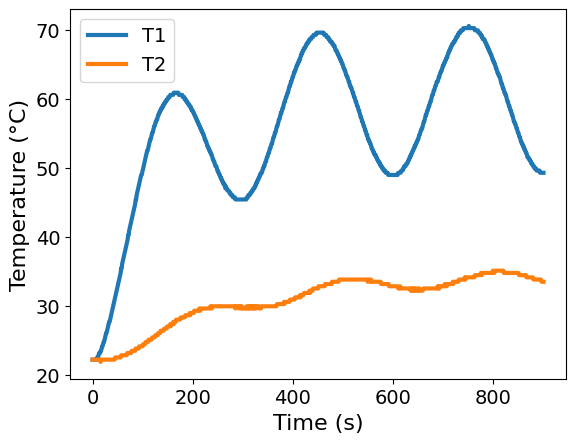

In [4]:
ax = df.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')

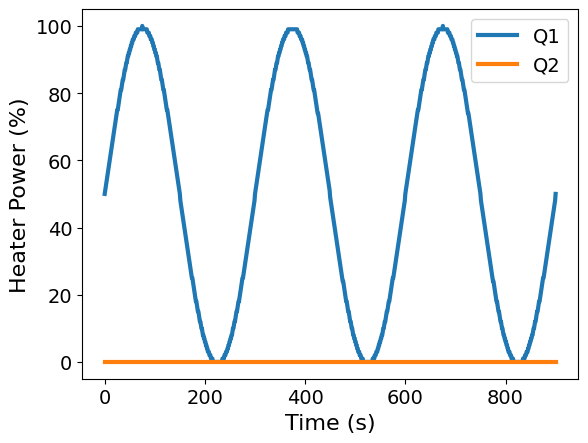

In [5]:
ax = df.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')

In [6]:
# Here, we will induce a step size of 6 seconds, as to not give too many 
# degrees of freedom for experimental design.
skip = 6

# Create the data object considering the new control points every 6 seconds
tc_data = TC_Lab_data(
    name="Sine Wave Test for Heater 1",
    time=df['Time'].values[::skip],
    T1=df['T1'].values[::skip],
    u1=df['Q1'].values[::skip],
    P1=200,
    TS1_data=None,
    T2=df['T2'].values[::skip],
    u2=df['Q2'].values[::skip],
    P2=200,
    TS2_data=None,
    Tamb=df['T1'].values[0],
)

## Analyze FIM with Pyomo.DoE at initial point (sine test)

In [7]:
# Load Pyomo.DoE class
from pyomo.contrib.doe import DesignOfExperiments

from pyomo.environ import SolverFactory

# Copied from previous notebook
theta_values = {
    'Ua': 0.0417051733576387,
    'Ub': 0.009440714239773074,
    'inv_CpH': 0.1659093525658045,
    'inv_CpS': 5.8357556063605465,
}

## Reusing the Experiment object used for parameter estimation

Recall that we utilized the experiment object during parameter estimation. From the Experiment Abstraction notebook, we labeled the important sets:

* ``experiment_inputs`` - The experimental design decisions (control variables $u_2$ in this case)
* ``experiment_outputs`` - The values measured during the experiment (temperature sensor data $T_{S1}$ in this case)
* ``measurement_error`` - The error associated with individual values measured during the experiment
* ``unknown_parameters`` - Those parameters in the model that are estimated using the measured values during the experiment (heat transfer coefficients ($U_a$ and $U_b$) and heat capacities ($C^H_p$ and $C^S_p$) in this case)

This means we can use the same experiment object for optimal DoE! Therefore, we go about creating this object in the same way, except we will specify the values of the unknown parameters, $\theta$.

In [8]:
# Create experiment object for design of experiments
doe_experiment = TC_Lab_experiment(data=tc_data, theta_initial=theta_values, number_of_states=number_tclab_states)

# Create the design of experiments object using our experiment instance from above
TC_Lab_DoE = DesignOfExperiments(experiment=doe_experiment, 
                                 step=1e-2,
                                 scale_constant_value=1,
                                 scale_nominal_param_value=True, 
                                 tee=True,)

FIM = TC_Lab_DoE.compute_FIM(method='sequential')

In [9]:
results_summary(FIM)

======Results Summary======
Four design criteria log10() value:
A-optimality: 5.773228885932493
D-optimality: 12.308607163946094
E-optimality: -1.793074158088514
Modified E-optimality: 7.514721752736364

FIM:
 [[517225.40941304   1360.01262476 -66404.72541298  -1002.47319402]
 [  1360.01262476   5004.3737258   12379.2662576    5238.40389773]
 [-66404.72541298  12379.2662576   65481.16908635  14190.01468139]
 [ -1002.47319402   5238.40389773  14190.01468139   5526.94375493]]

eigenvalues:
 [5.26802218e+05 6.26035823e+04 3.83207978e+03 1.61037063e-02]

eigenvectors:
 [[-9.89752804e-01 -1.35949591e-01  4.36702406e-02 -7.52086327e-05]
 [ 8.63262440e-04 -2.26164575e-01 -6.85698047e-01 -6.91857665e-01]
 [ 1.42671125e-01 -9.31600001e-01  3.33329462e-01 -2.56487437e-02]
 [ 5.79584008e-03 -2.49977462e-01 -6.45602485e-01  7.21578207e-01]]


We can see the FIM of the sine wave experiment is rank deficient with one eigenvalue that is numerically zero. We see the corresponding eigenvector points in the direction of the 2nd and 4th parameters, `U_b` and `inv_CpS`. This means the experiment alone does not contain enough information to uniquely estimate all of the parameters if the model.

Why does it make sense that $U_b C_p^S$ is difficult to estimate?

## Define parameterized sine wave experiment

Can we further optimize the sine wave test to improve the information content? Let's define the parameterized sine wave as:

$$
u(t) = 50 + a \sin(\frac{2 \pi}{60 p} t)
$$

where $a$ is the amplitude (% power), $p$ is the period (minutes), $t$ is the time (seconds), and 60 is a conversion factor (seconds/minute).

Let's look at the information content of $p = 5$ minute and $a = 50$ %.

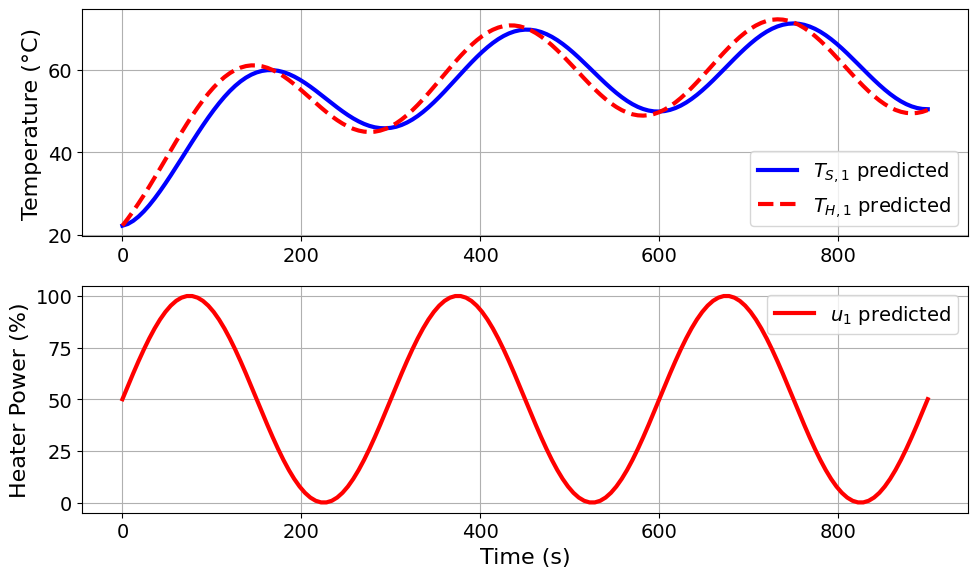

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 5 minutes
u1_amplitude = 50 % power
 


In [10]:
# Create experiment object for design of experiments, now including the sine period and amplitude
sine_period = 5
sine_amplitude = 50

doe_experiment = TC_Lab_experiment(
    data=tc_data, 
    theta_initial=theta_values, 
    number_of_states=number_tclab_states, 
    sine_amplitude=sine_amplitude,
    sine_period=sine_period,
)

# Create the design of experiments object using our experiment instance from above
TC_Lab_DoE = DesignOfExperiments(experiment=doe_experiment, 
                                 step=1e-2,
                                 scale_constant_value=1,
                                 scale_nominal_param_value=True, 
                                 tee=True,)

FIM = TC_Lab_DoE.compute_FIM(method='sequential')

pyomo_doe_results = extract_plot_results(None, TC_Lab_DoE.compute_FIM_model)

In [11]:
results_summary(FIM)

======Results Summary======
Four design criteria log10() value:
A-optimality: 5.780415236175106
D-optimality: 12.321221800291308
E-optimality: -1.7900021808076725
Modified E-optimality: 7.519483927119054

FIM:
 [[526615.93104322   1269.39017779 -67742.74020183  -1135.81765702]
 [  1269.39017779   5002.22184096  12430.15508962   5238.07864931]
 [-67742.74020183  12430.15508962  65988.9240756   14256.31640107]
 [ -1135.81765702   5238.07864931  14256.31640107   5528.90185893]]

eigenvalues:
 [5.36391326e+05 6.29165915e+04 3.82804512e+03 1.62180195e-02]

eigenvectors:
 [[-9.89741606e-01 -1.36133505e-01  4.33499251e-02 -7.45344234e-05]
 [ 1.03341873e-03 -2.25549256e-01 -6.85896472e-01 -6.91861616e-01]
 [ 1.42740848e-01 -9.31879387e-01  3.32518176e-01 -2.56421659e-02]
 [ 5.96112603e-03 -2.49391279e-01 -6.45831616e-01  7.21574652e-01]]


This parameterization reproduced the original sine wave experiment. As expected, the FIM is still rank deficient.

## Perform sensitivity analysis to sine wave frequency and period

Now let's perform a sensitivity analysis over $p$ and $a$. `Pyomo.DoE` includes functions to automate this analysis including visualization. In our experience, an exploratory analysis like this is especially helpful to develop intuition about the physical system and model.

In [12]:
# Design variable ranges as lists
quick_run = False

if not quick_run:
    # Larger sensitivity analysis with more detailed plots
    design_ranges = {
        "u1_period": [1, 2, 3, 4, 5, 6, 7, 8],
        "u1_amplitude": [15, 25, 35, 45],
    }
else:
    # Faster sensitivity analysis, good for debugging
    design_ranges = {"u1_period": [1, 2], "u1_amplitude": [20, 50]}

sensi_opt = "sequential_finite"

=======Iteration Number: 1 =======
Design variable values for this iteration: (Period: 1, Amplitude: 15)


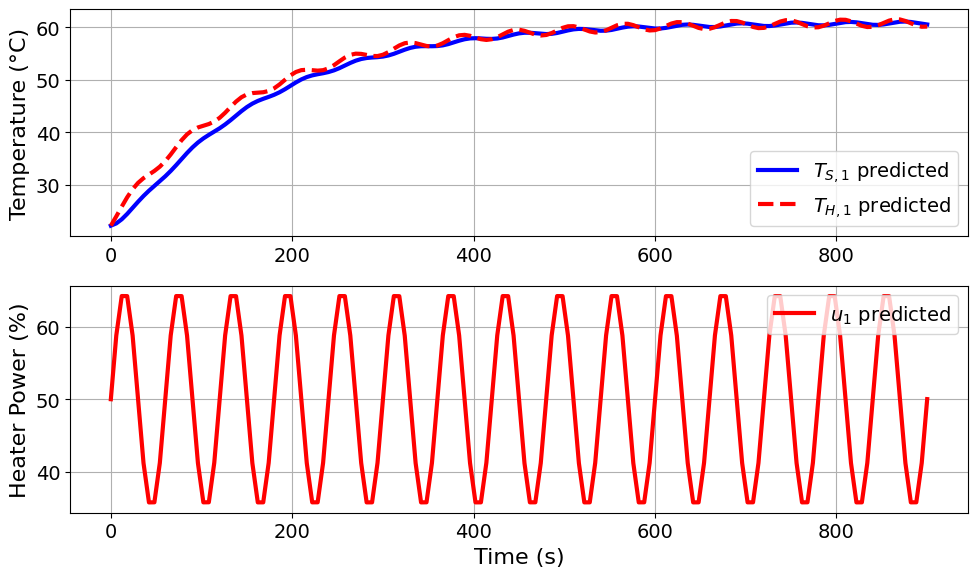

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 1 minutes
u1_amplitude = 15 % power
 
=======Iteration Number: 2 =======
Design variable values for this iteration: (Period: 1, Amplitude: 25)


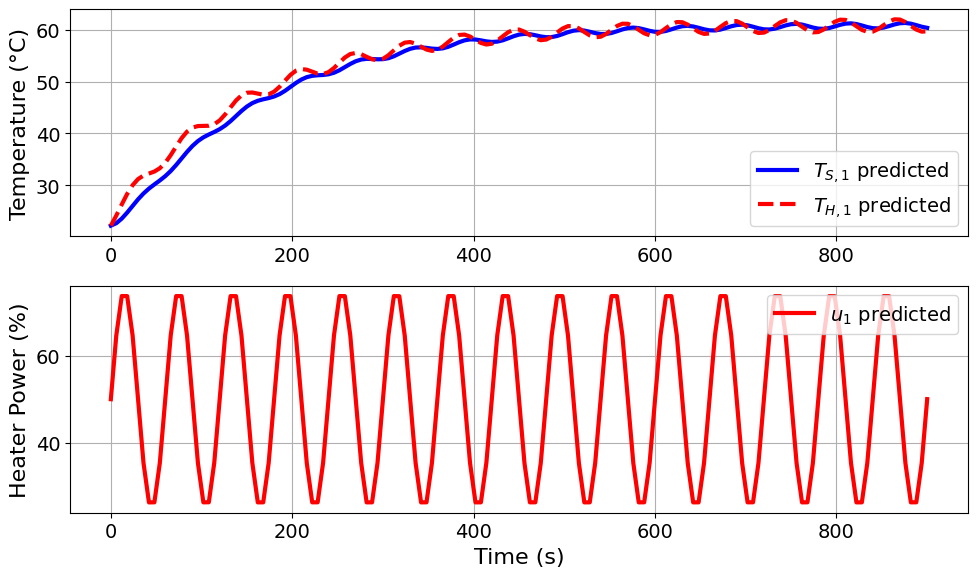

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 1 minutes
u1_amplitude = 25 % power
 
=======Iteration Number: 3 =======
Design variable values for this iteration: (Period: 1, Amplitude: 35)


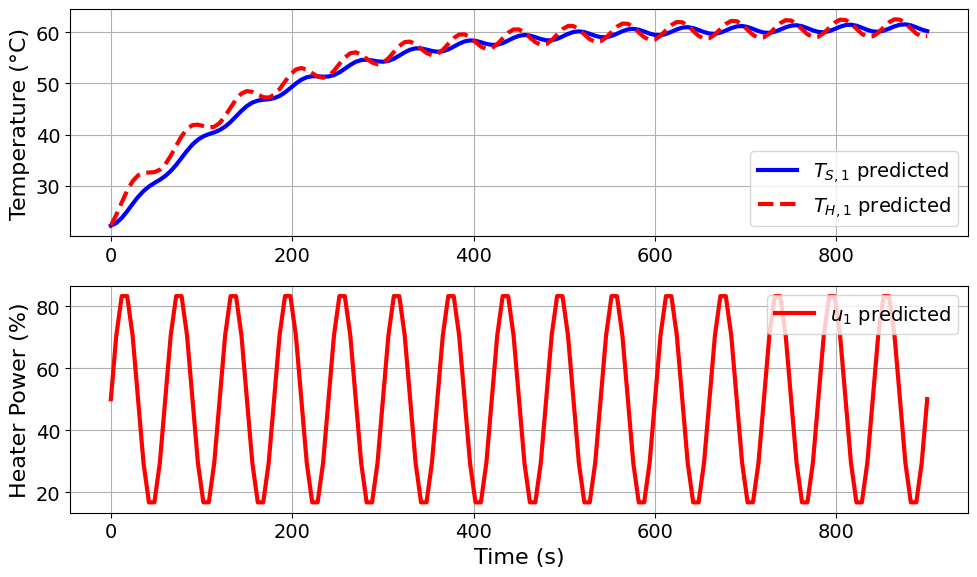

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 1 minutes
u1_amplitude = 35 % power
 
=======Iteration Number: 4 =======
Design variable values for this iteration: (Period: 1, Amplitude: 45)


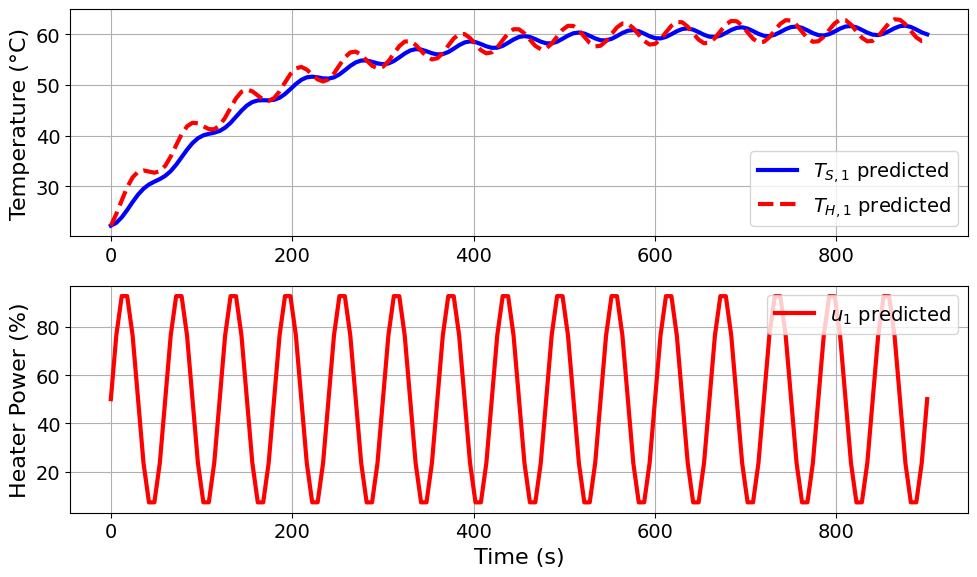

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 1 minutes
u1_amplitude = 45 % power
 
=======Iteration Number: 5 =======
Design variable values for this iteration: (Period: 2, Amplitude: 15)


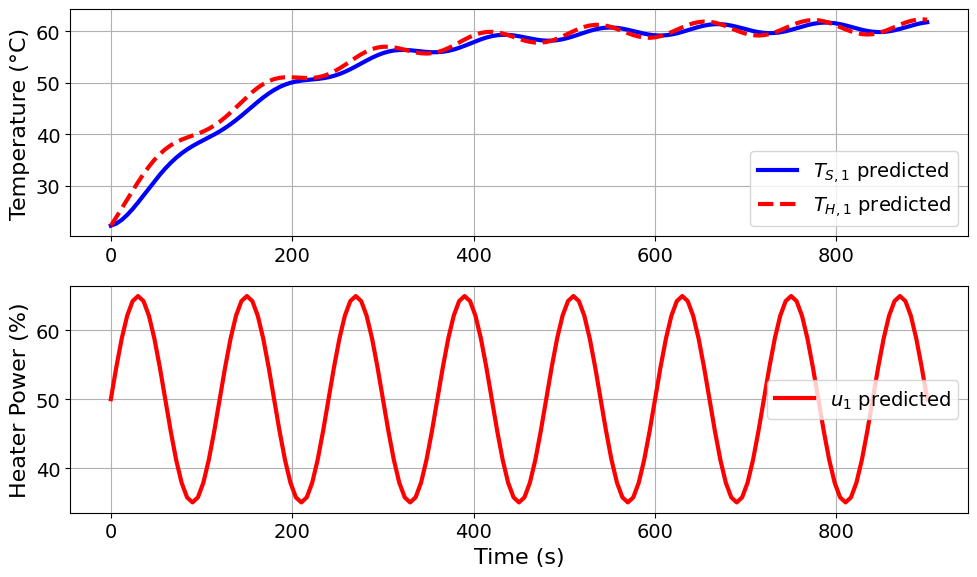

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 2 minutes
u1_amplitude = 15 % power
 
=======Iteration Number: 6 =======
Design variable values for this iteration: (Period: 2, Amplitude: 25)


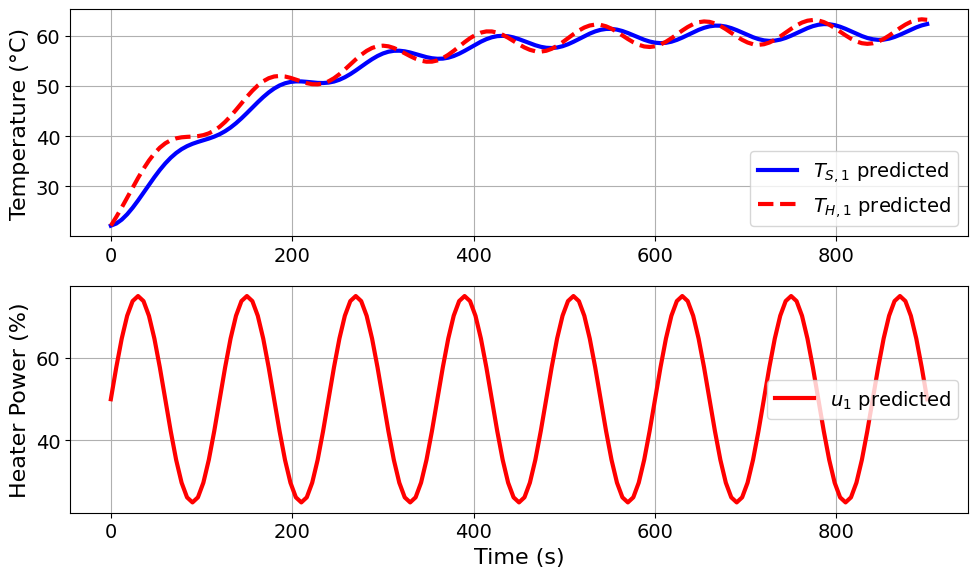

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 2 minutes
u1_amplitude = 25 % power
 
=======Iteration Number: 7 =======
Design variable values for this iteration: (Period: 2, Amplitude: 35)


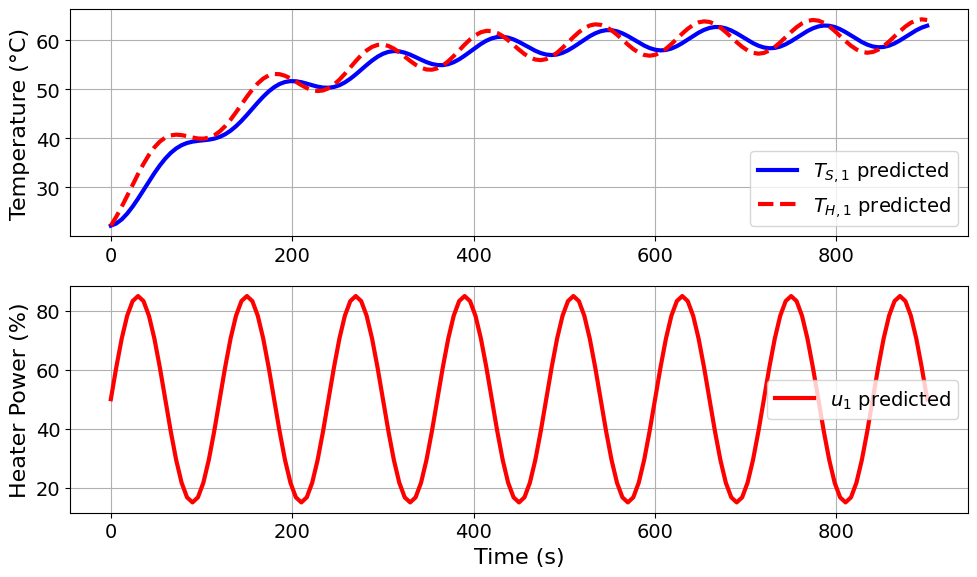

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 2 minutes
u1_amplitude = 35 % power
 
=======Iteration Number: 8 =======
Design variable values for this iteration: (Period: 2, Amplitude: 45)


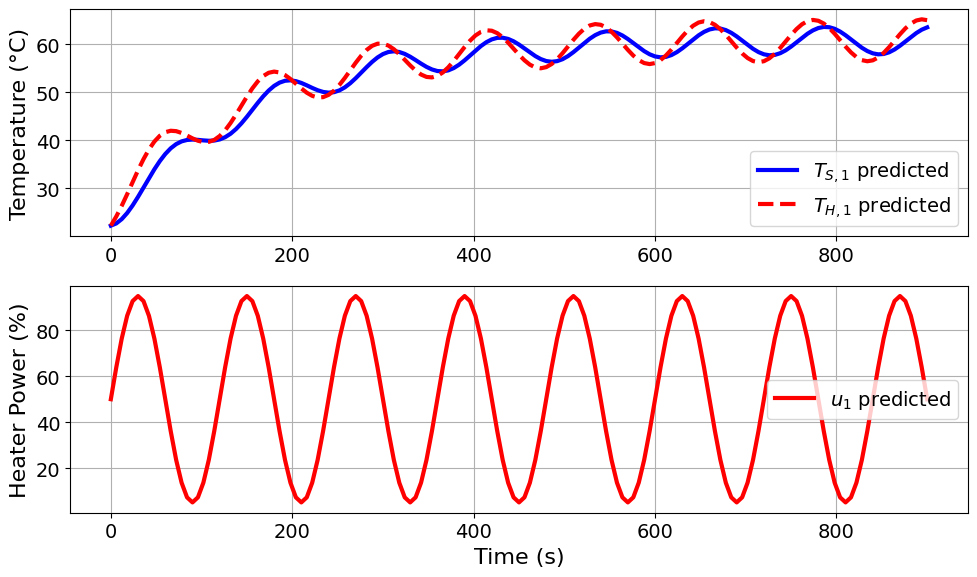

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 2 minutes
u1_amplitude = 45 % power
 
=======Iteration Number: 9 =======
Design variable values for this iteration: (Period: 3, Amplitude: 15)


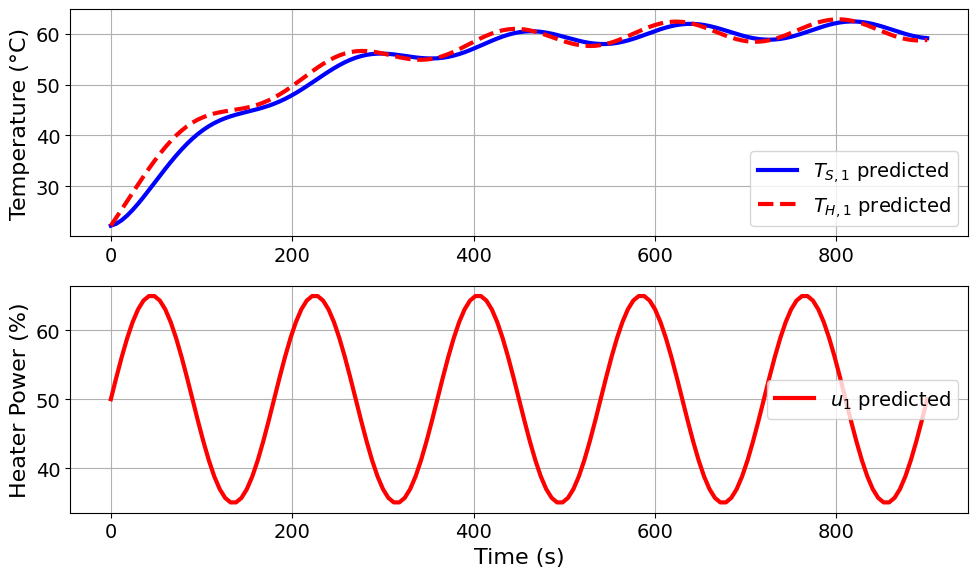

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 3 minutes
u1_amplitude = 15 % power
 
=======Iteration Number: 10 =======
Design variable values for this iteration: (Period: 3, Amplitude: 25)


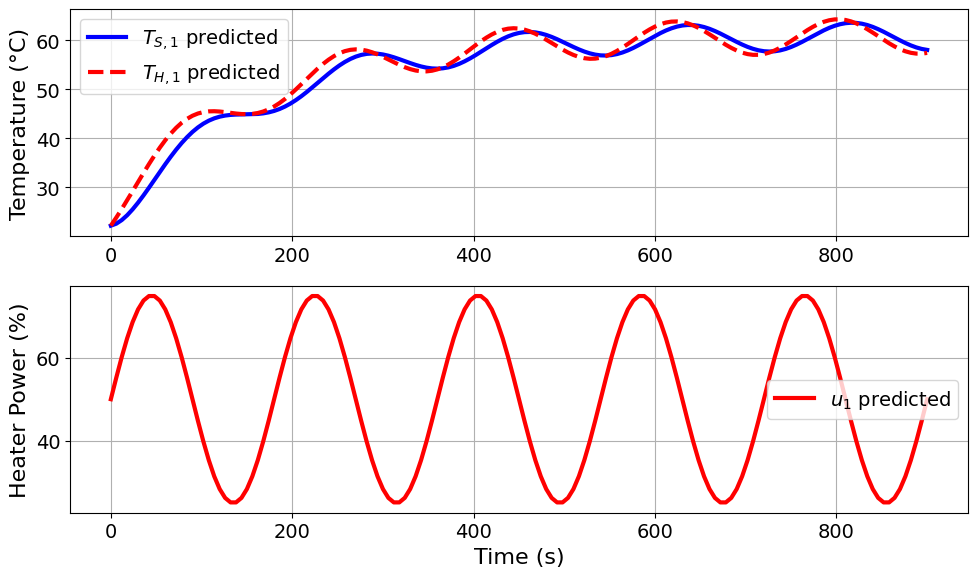

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 3 minutes
u1_amplitude = 25 % power
 
=======Iteration Number: 11 =======
Design variable values for this iteration: (Period: 3, Amplitude: 35)


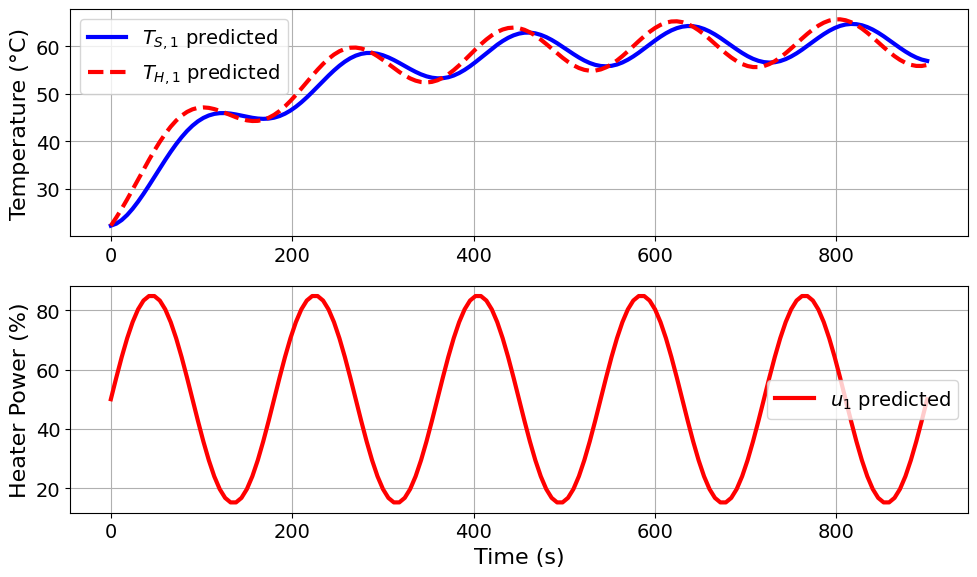

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 3 minutes
u1_amplitude = 35 % power
 
=======Iteration Number: 12 =======
Design variable values for this iteration: (Period: 3, Amplitude: 45)


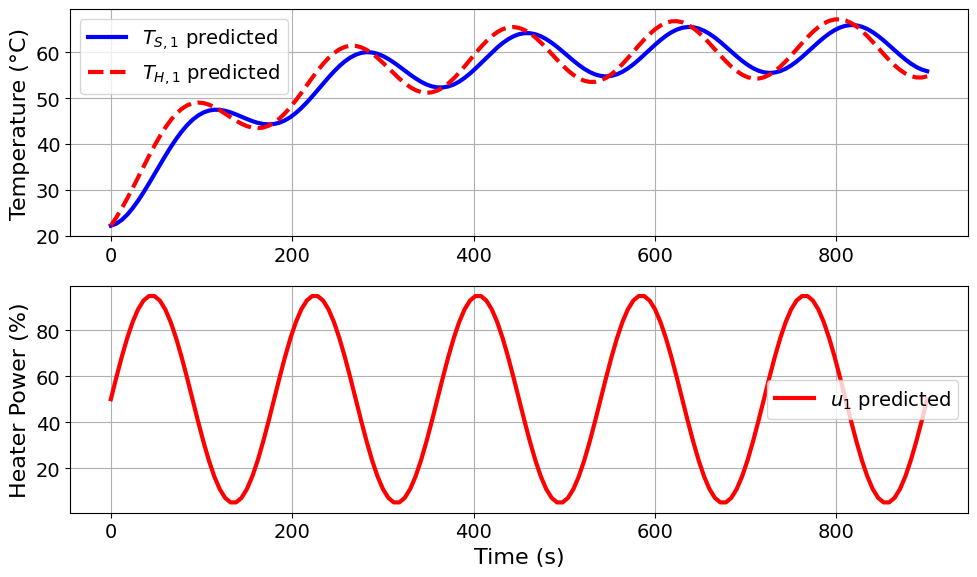

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 3 minutes
u1_amplitude = 45 % power
 
=======Iteration Number: 13 =======
Design variable values for this iteration: (Period: 4, Amplitude: 15)


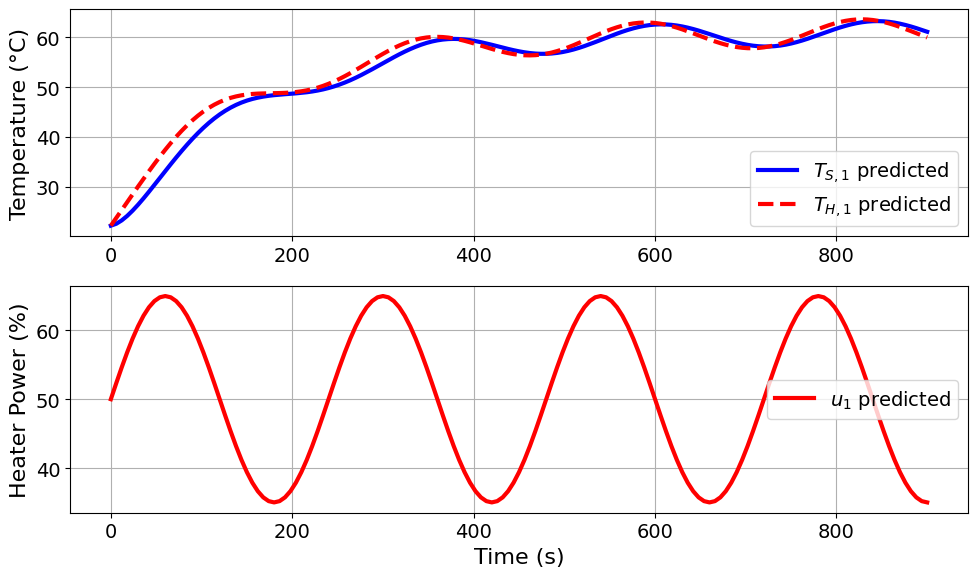

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 4 minutes
u1_amplitude = 15 % power
 
=======Iteration Number: 14 =======
Design variable values for this iteration: (Period: 4, Amplitude: 25)


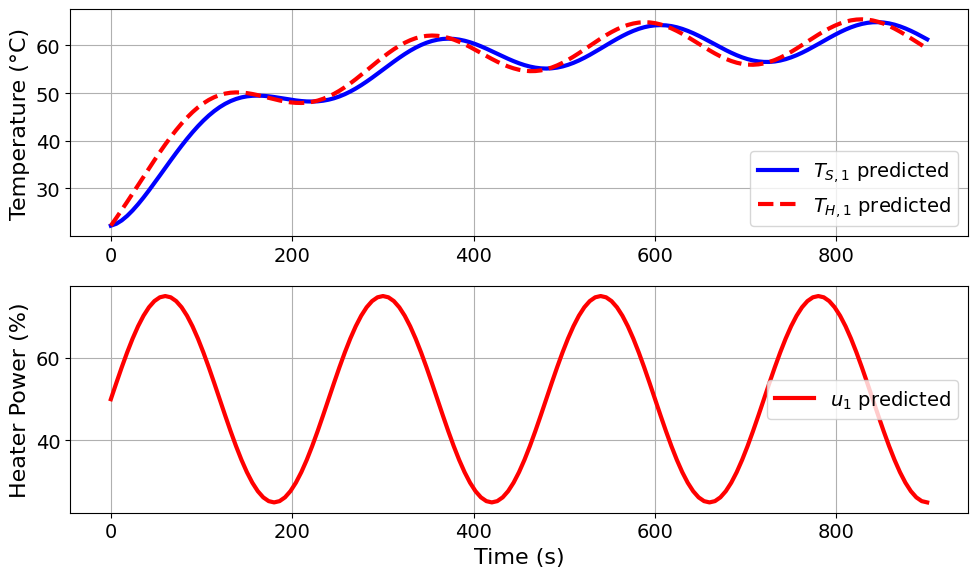

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 4 minutes
u1_amplitude = 25 % power
 
=======Iteration Number: 15 =======
Design variable values for this iteration: (Period: 4, Amplitude: 35)


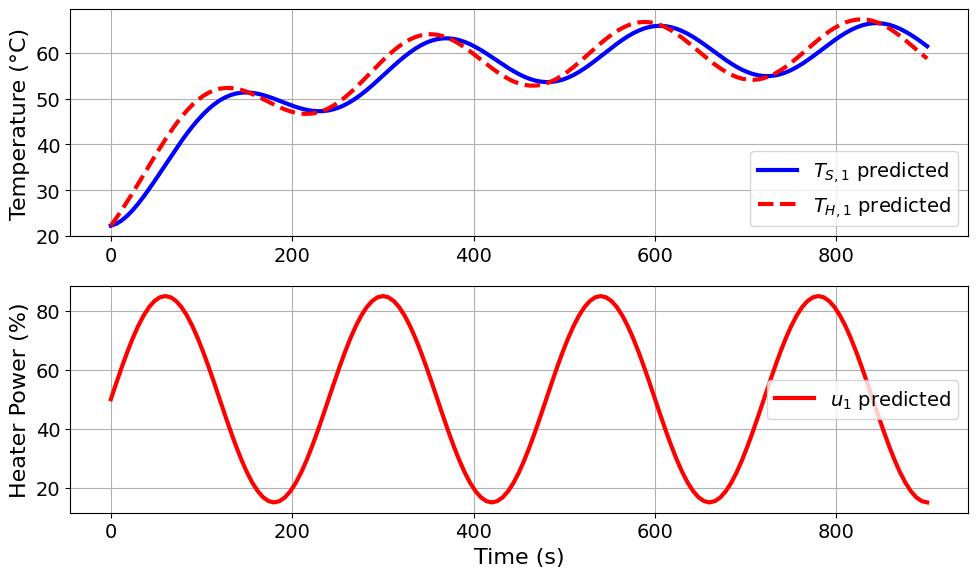

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 4 minutes
u1_amplitude = 35 % power
 
=======Iteration Number: 16 =======
Design variable values for this iteration: (Period: 4, Amplitude: 45)


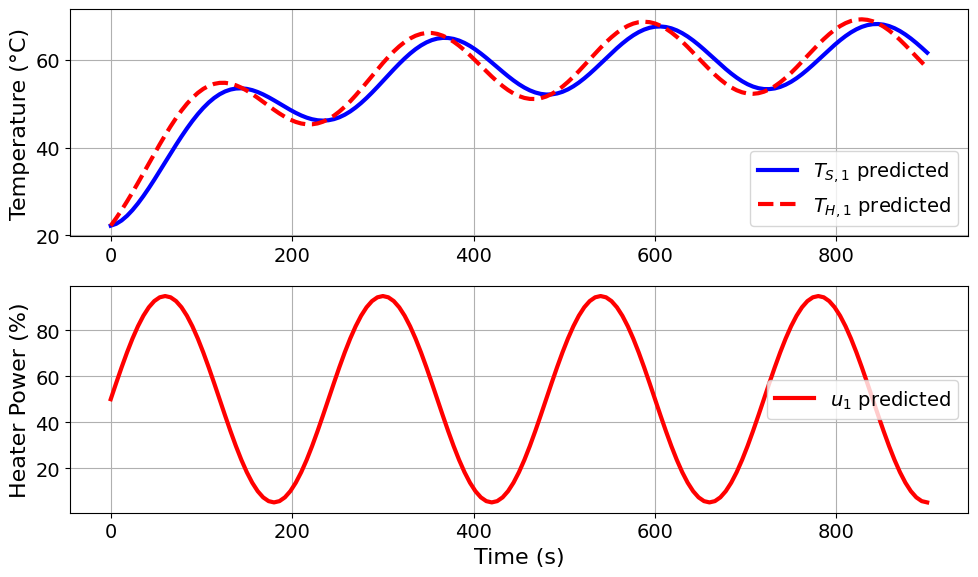

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 4 minutes
u1_amplitude = 45 % power
 
=======Iteration Number: 17 =======
Design variable values for this iteration: (Period: 5, Amplitude: 15)


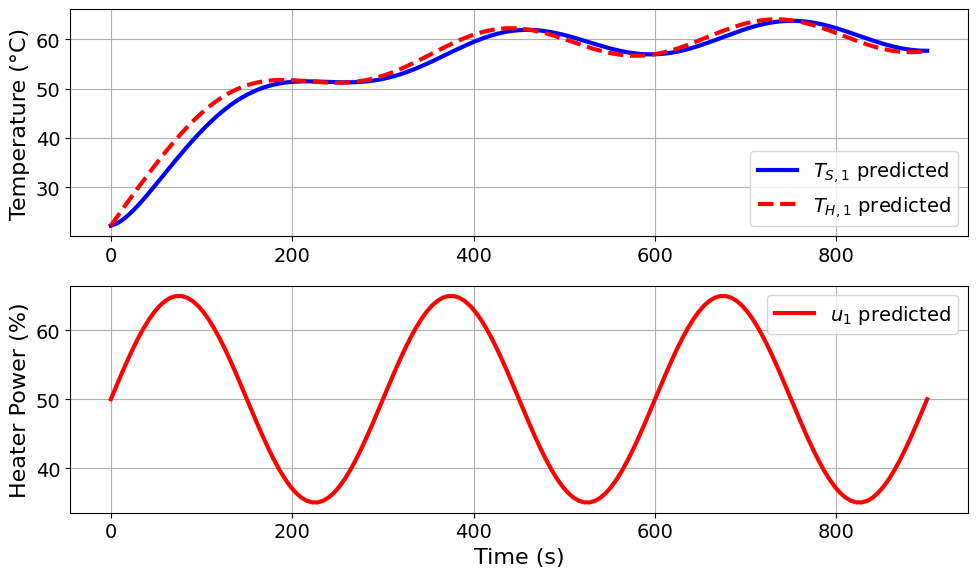

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 5 minutes
u1_amplitude = 15 % power
 
=======Iteration Number: 18 =======
Design variable values for this iteration: (Period: 5, Amplitude: 25)


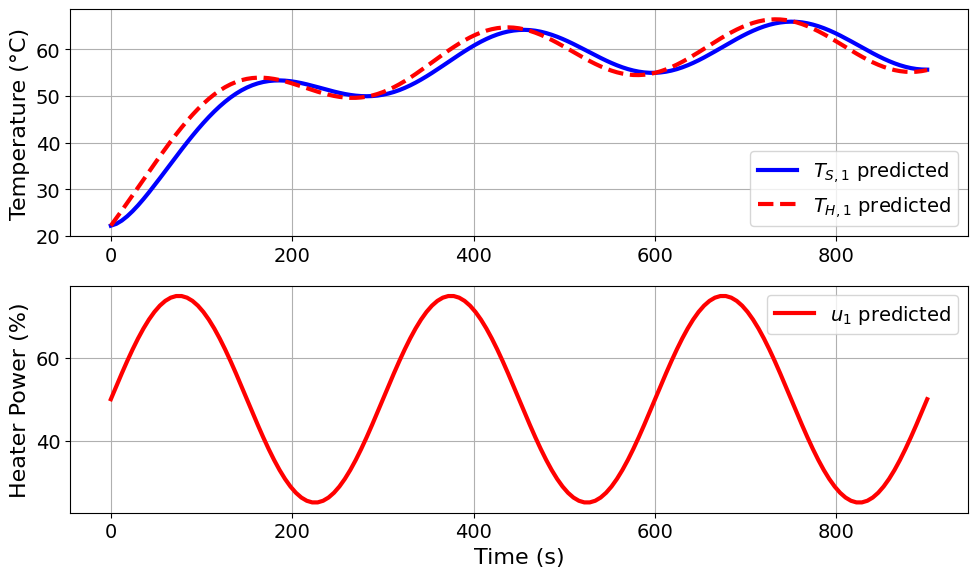

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 5 minutes
u1_amplitude = 25 % power
 
=======Iteration Number: 19 =======
Design variable values for this iteration: (Period: 5, Amplitude: 35)


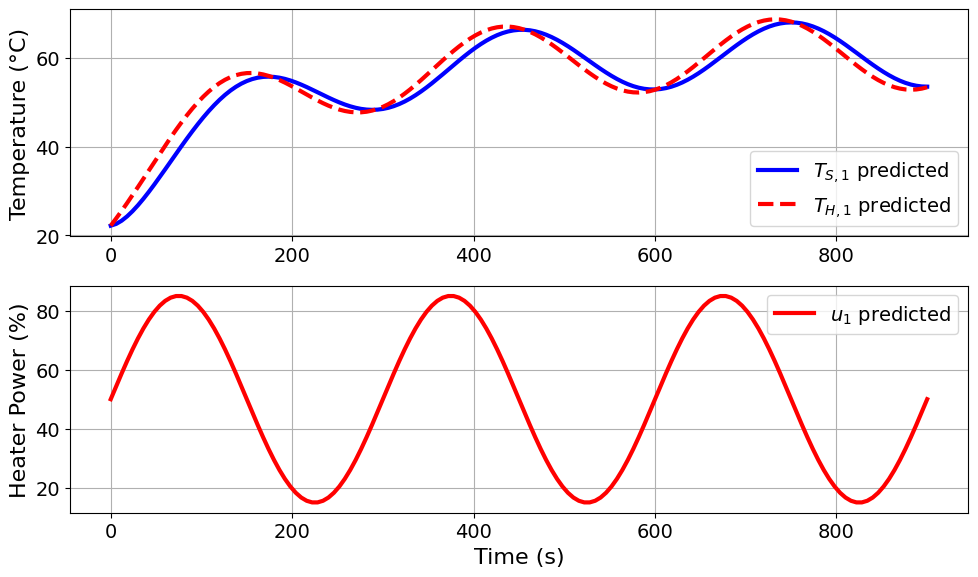

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 5 minutes
u1_amplitude = 35 % power
 
=======Iteration Number: 20 =======
Design variable values for this iteration: (Period: 5, Amplitude: 45)


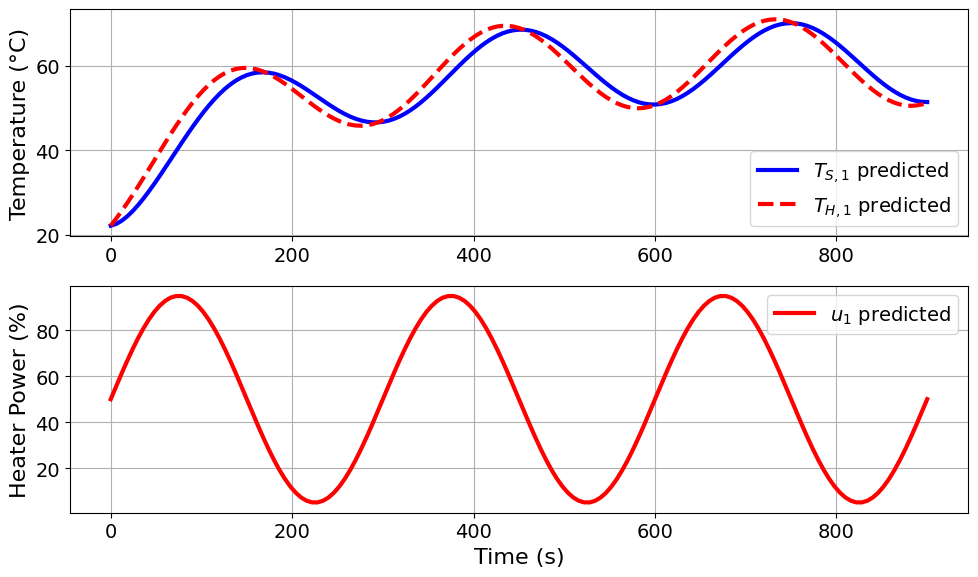

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 5 minutes
u1_amplitude = 45 % power
 
=======Iteration Number: 21 =======
Design variable values for this iteration: (Period: 6, Amplitude: 15)


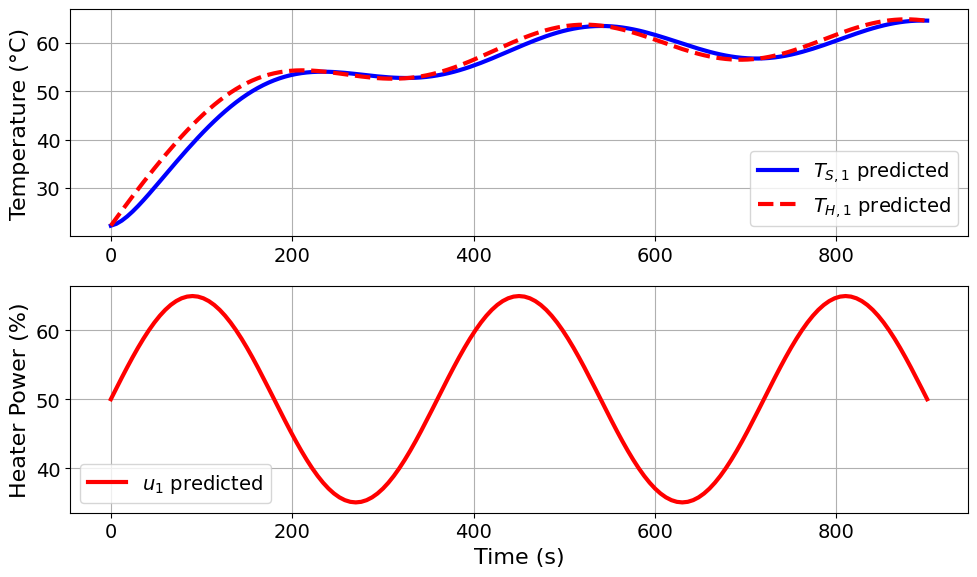

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 6 minutes
u1_amplitude = 15 % power
 
=======Iteration Number: 22 =======
Design variable values for this iteration: (Period: 6, Amplitude: 25)


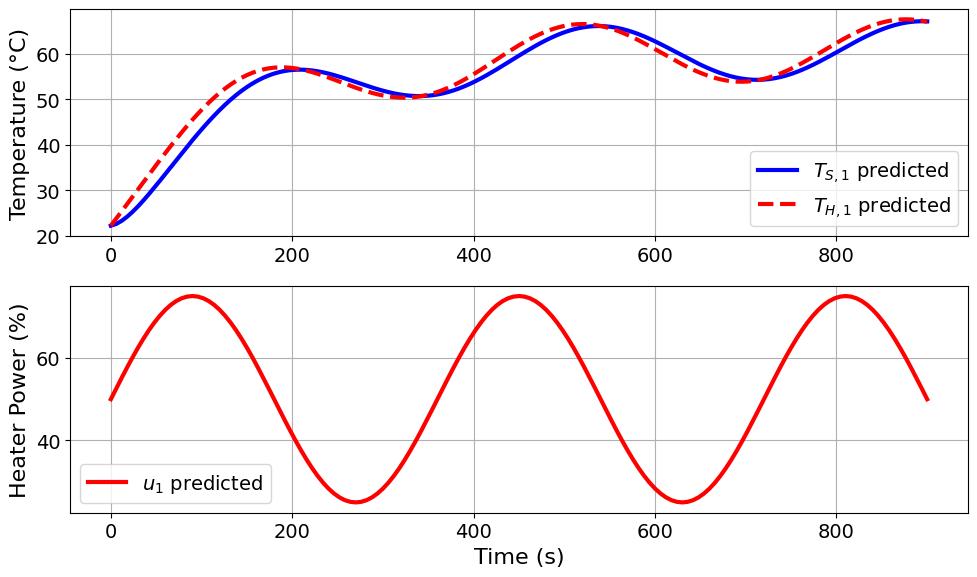

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 6 minutes
u1_amplitude = 25 % power
 
=======Iteration Number: 23 =======
Design variable values for this iteration: (Period: 6, Amplitude: 35)


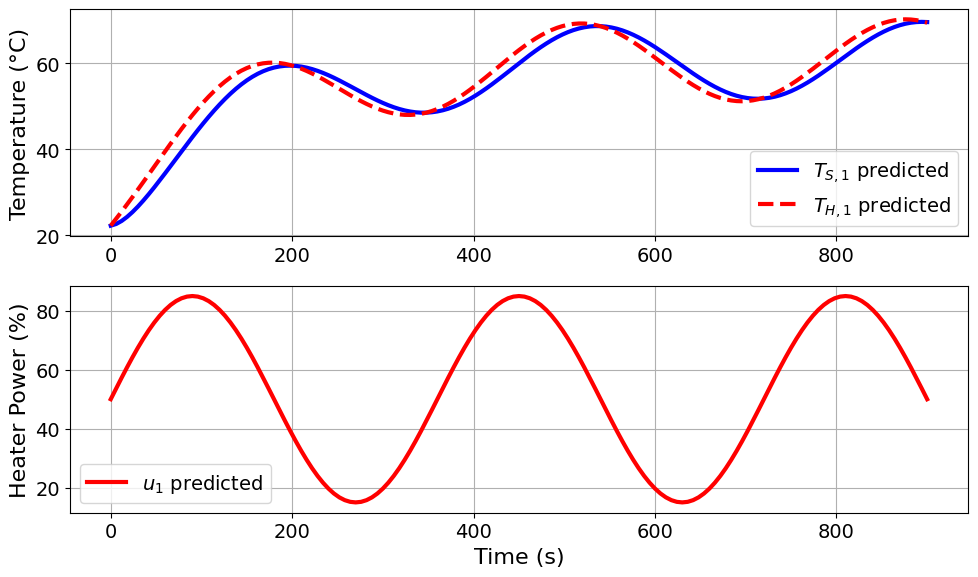

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 6 minutes
u1_amplitude = 35 % power
 
=======Iteration Number: 24 =======
Design variable values for this iteration: (Period: 6, Amplitude: 45)


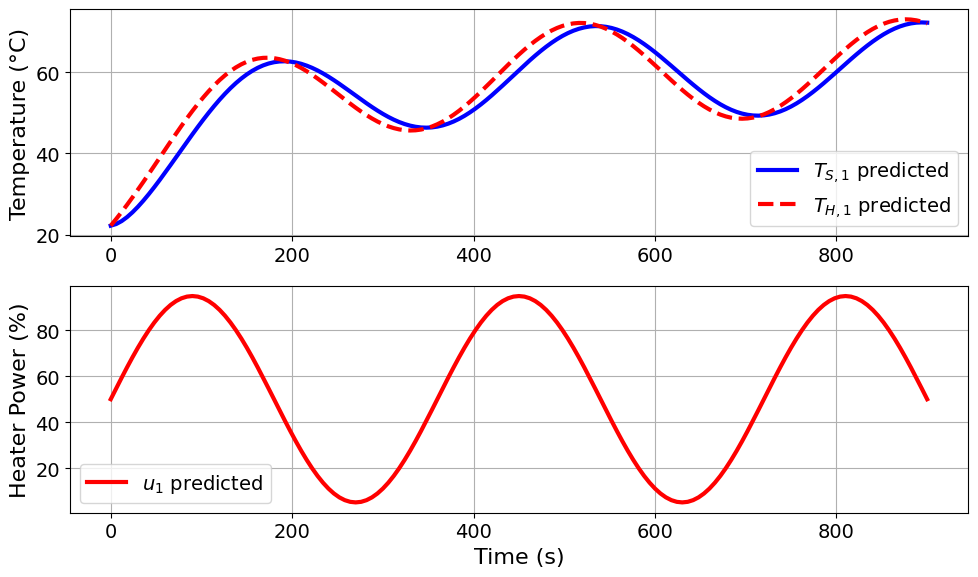

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 6 minutes
u1_amplitude = 45 % power
 
=======Iteration Number: 25 =======
Design variable values for this iteration: (Period: 7, Amplitude: 15)


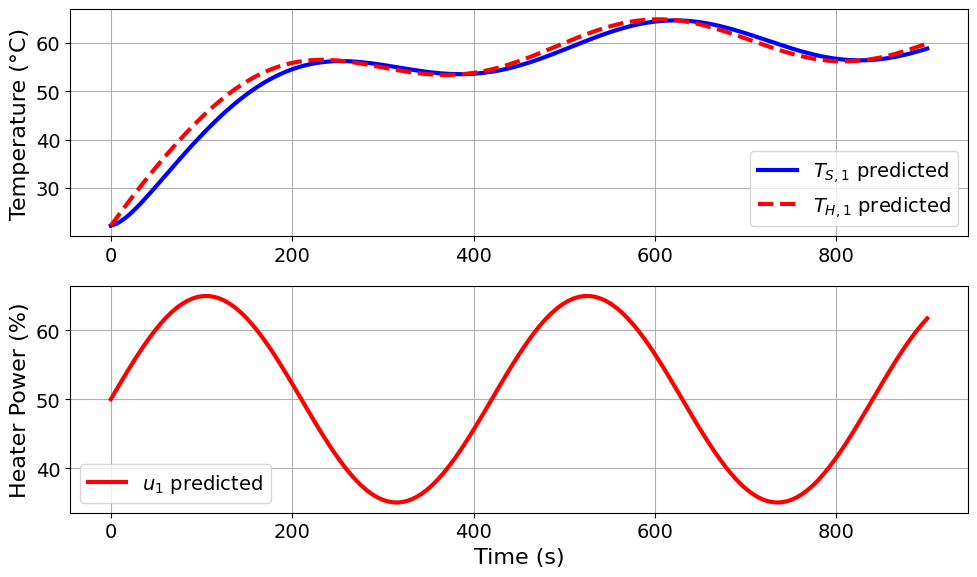

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 7 minutes
u1_amplitude = 15 % power
 
=======Iteration Number: 26 =======
Design variable values for this iteration: (Period: 7, Amplitude: 25)


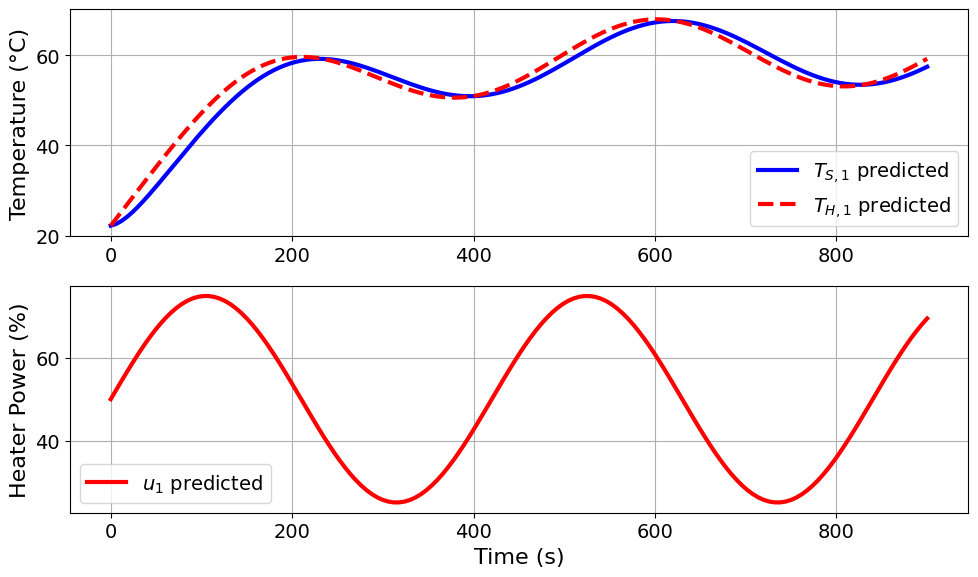

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 7 minutes
u1_amplitude = 25 % power
 
=======Iteration Number: 27 =======
Design variable values for this iteration: (Period: 7, Amplitude: 35)


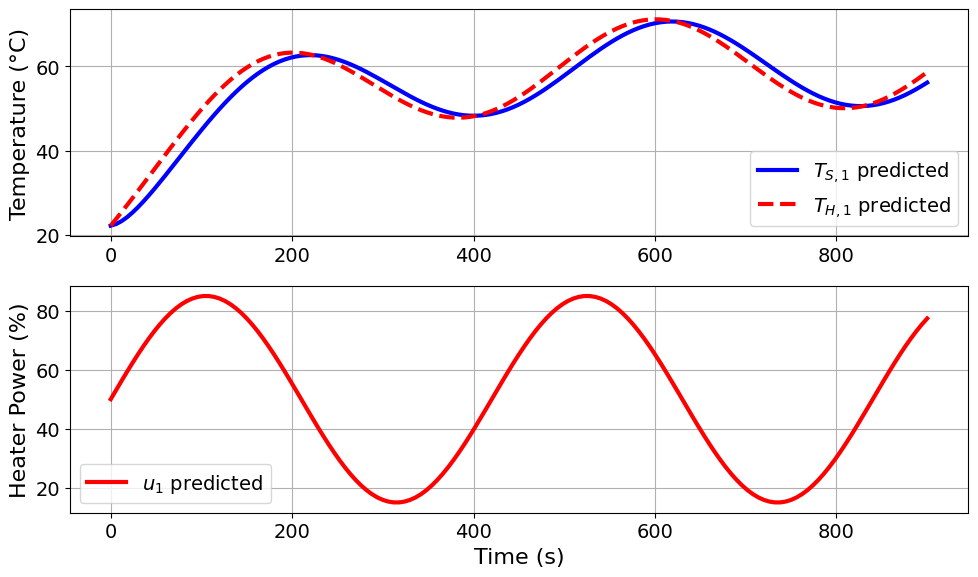

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 7 minutes
u1_amplitude = 35 % power
 
=======Iteration Number: 28 =======
Design variable values for this iteration: (Period: 7, Amplitude: 45)


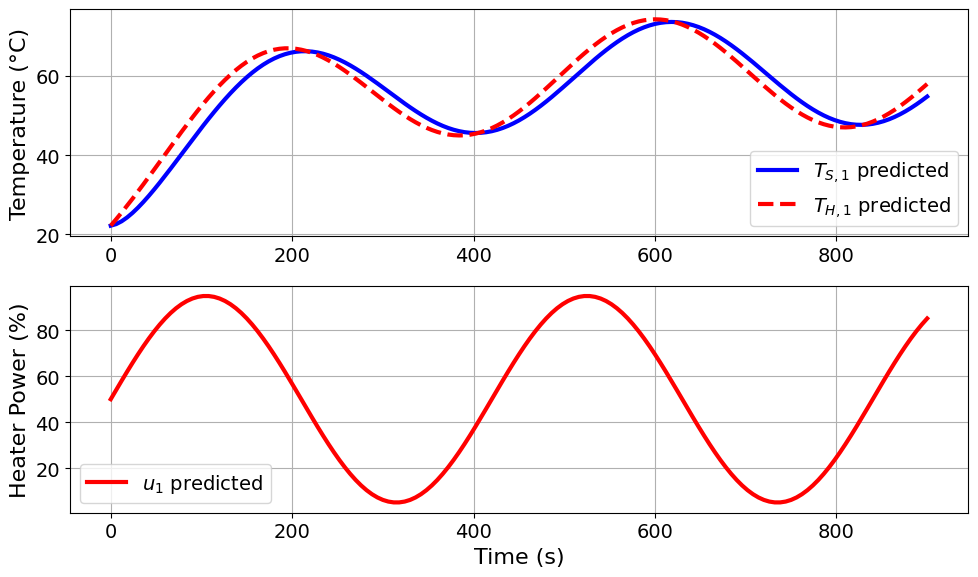

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 7 minutes
u1_amplitude = 45 % power
 
=======Iteration Number: 29 =======
Design variable values for this iteration: (Period: 8, Amplitude: 15)


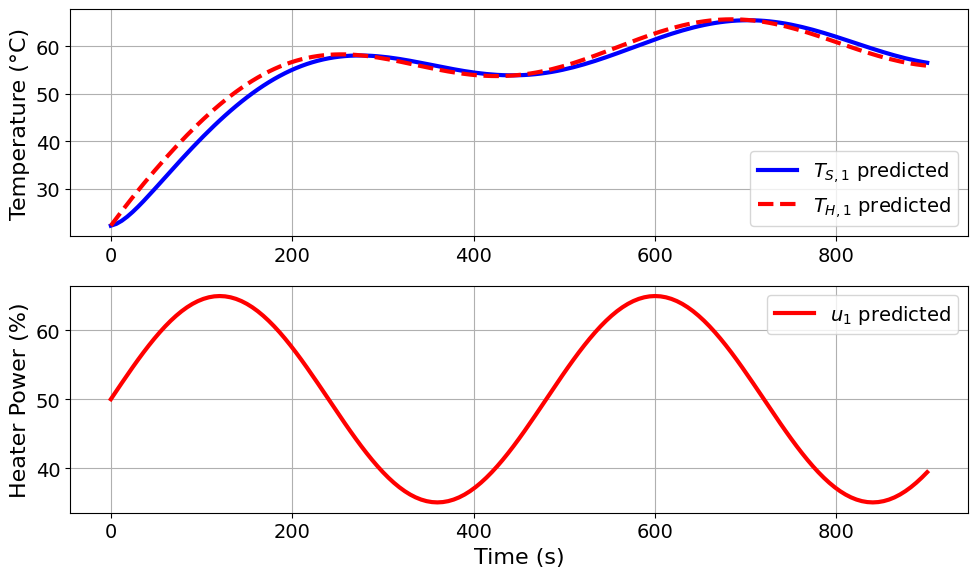

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 8 minutes
u1_amplitude = 15 % power
 
=======Iteration Number: 30 =======
Design variable values for this iteration: (Period: 8, Amplitude: 25)


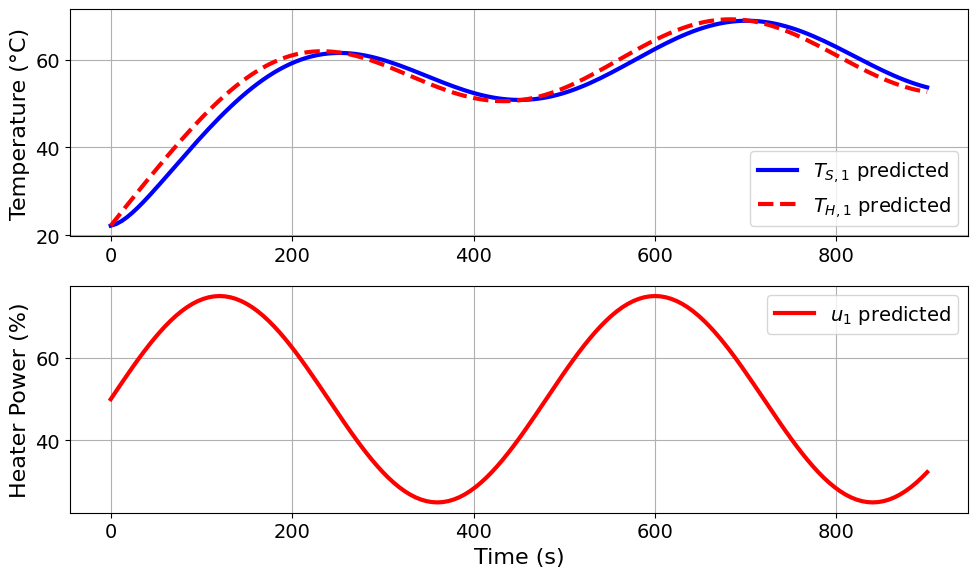

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 8 minutes
u1_amplitude = 25 % power
 
=======Iteration Number: 31 =======
Design variable values for this iteration: (Period: 8, Amplitude: 35)


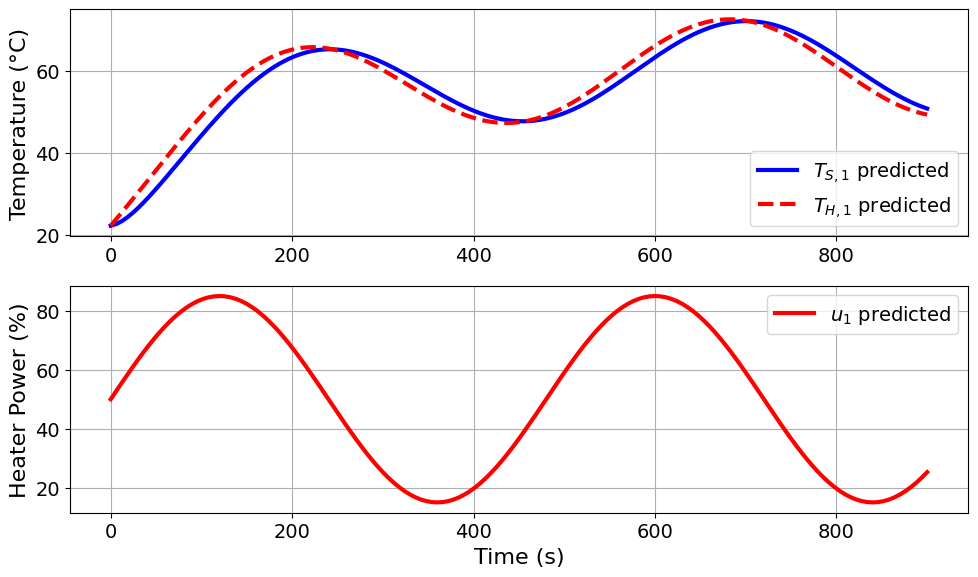

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 8 minutes
u1_amplitude = 35 % power
 
=======Iteration Number: 32 =======
Design variable values for this iteration: (Period: 8, Amplitude: 45)


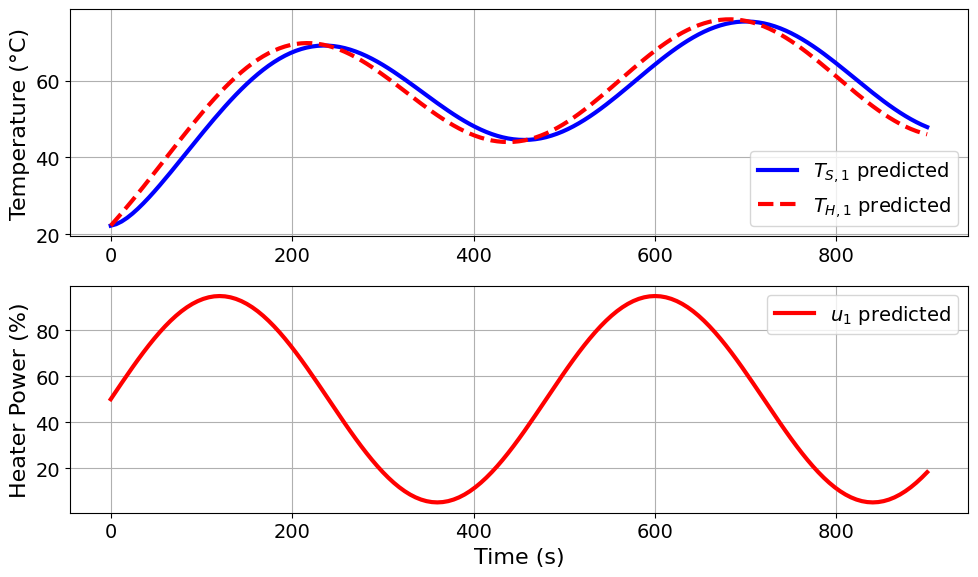

Model parameters:
Ua = 0.0413 Watts/degC
Ub = 0.0093 Watts/degC
CpH = 6.0883 Joules/degC
CpS = 0.1731 Joules/degC
u1_period = 8 minutes
u1_amplitude = 45 % power
 


In [13]:
FIM_results = []
data_period = []
data_amplitude = []

count = 0
# Grid search
for period in design_ranges["u1_period"]:
    for amplitude in design_ranges["u1_amplitude"]:
        count += 1
        print("=======Iteration Number: {} =======".format(count))
        print("Design variable values for this iteration: (Period: {}, Amplitude: {})".format(period, amplitude))

        data_period.append(period)
        data_amplitude.append(amplitude)
        
        doe_experiment = TC_Lab_experiment(
            data=tc_data, 
            theta_initial=theta_values, 
            number_of_states=number_tclab_states, 
            sine_amplitude=amplitude,
            sine_period=period,
        )
        
        # Create the design of experiments object using our experiment instance from above
        TC_Lab_DoE = DesignOfExperiments(experiment=doe_experiment, 
                                         step=1e-2,
                                         scale_constant_value=1,
                                         scale_nominal_param_value=True, 
                                         tee=True,)
        
        FIM = TC_Lab_DoE.compute_FIM(method='sequential')
        
        pyomo_doe_results = extract_plot_results(None, TC_Lab_DoE.compute_FIM_model)

        FIM_results.append(FIM)

## Visualize and interpret sensitivity analysis results

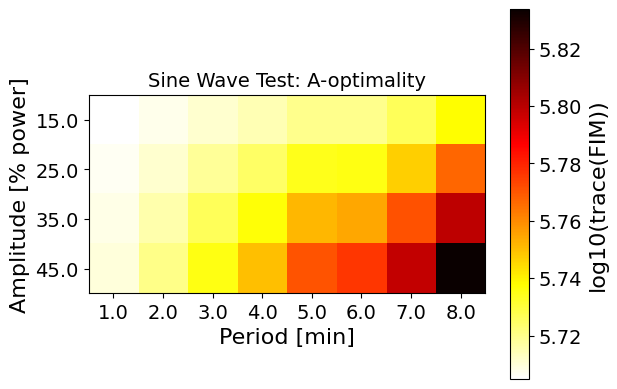

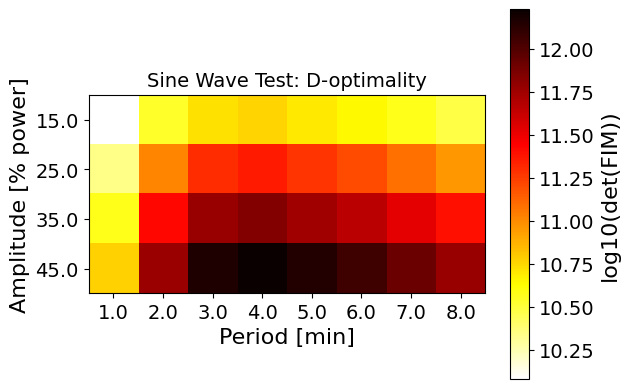

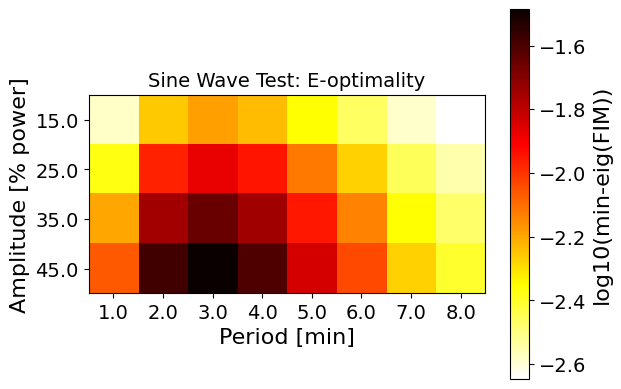

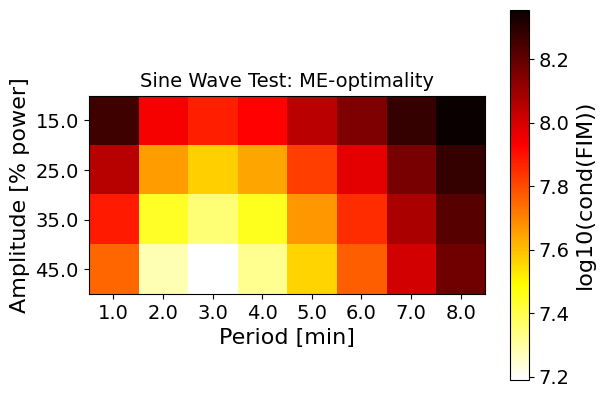

In [21]:
import numpy as np

# Extract criteria from FIM
def get_FIM_metrics(result):
    eigenvalues, eigenvectors = np.linalg.eig(result)
    min_eig = min(eigenvalues)

    A_opt = np.log10(np.trace(result))
    D_opt = np.log10(np.linalg.det(result))
    E_opt = np.log10(min_eig)
    ME_opt = np.log10(np.linalg.cond(result))

    return A_opt, D_opt, E_opt, ME_opt

FIM_metrics = []

for i in FIM_results:
    FIM_metrics.append(get_FIM_metrics(i))

FIM_metrics_np = np.asarray(FIM_metrics)

# Make heat map
def plot_heatmap(data, title, y_label, x_label, colorbar_label):
    # set heatmap x,y ranges
    x_tick_labels = np.sort(np.unique(data[:, 0]))
    y_tick_labels = np.sort(np.unique(data[:, 1]))

    # optimality-values
    opt_vals = np.asarray(data[:, 2]).reshape(len(x_tick_labels), len(y_tick_labels))
    
    # Plot the colormap
    fig = plt.figure()

    # Plotting options
    ax = fig.add_subplot(111)
    params = {"mathtext.default": "regular"}
    plt.rcParams.update(params)

    # Plotting data
    ax.set_yticks(range(len(y_tick_labels)))
    ax.set_yticklabels(y_tick_labels)
    ax.set_ylabel(y_label)
    ax.set_xticks(range(len(x_tick_labels)))
    ax.set_xticklabels(x_tick_labels)
    ax.set_xlabel(x_label)
    im = ax.imshow(opt_vals.T, cmap=plt.cm.hot_r)
    ba = plt.colorbar(im)
    ba.set_label(colorbar_label)
    plt.title(title)

# X and Y axis labels
x_label = "Period [min]"
y_label = "Amplitude [% power]"

# Draw A-optimality figure
data_A = np.zeros((len(FIM_metrics), 3))
data_A[:, 0] = data_period
data_A[:, 1] = data_amplitude
data_A[:, 2] = FIM_metrics_np[:, 0]

plot_heatmap(data_A, "Sine Wave Test: A-optimality", y_label, x_label, "log10(trace(FIM))")

# Draw D-optimality figure
data_D = np.zeros((len(FIM_metrics), 3))
data_D[:, 0] = data_period
data_D[:, 1] = data_amplitude
data_D[:, 2] = FIM_metrics_np[:, 1]

plot_heatmap(data_D, "Sine Wave Test: D-optimality", y_label, x_label, "log10(det(FIM))")

# Draw E-optimality figure
data_E = np.zeros((len(FIM_metrics), 3))
data_E[:, 0] = data_period
data_E[:, 1] = data_amplitude
data_E[:, 2] = FIM_metrics_np[:, 2]

plot_heatmap(data_E, "Sine Wave Test: E-optimality", y_label, x_label, "log10(min-eig(FIM))")

# Draw ME-optimality figure
data_ME = np.zeros((len(FIM_metrics), 3))
data_ME[:, 0] = data_period
data_ME[:, 1] = data_amplitude
data_ME[:, 2] = FIM_metrics_np[:, 3]

plot_heatmap(data_ME, "Sine Wave Test: ME-optimality", y_label, x_label, "log10(cond(FIM))")

These heatmaps tell us a lot about the mathematical model for the TCLab system.

A-optimality (trace of FIM) is the largest with a long period (8 minutes) and large amplitude (45%). Why does this make sense? The long period means the heating and cooling is more gradual. This gives more information about the dynamics of the system, especially the lag in heat transfer between the two modeled thermal masses. Likewise, the larger amplitude ensures a larger temperature range is explored, which maximizes the ratio of the signal to noise (which is assumed to be i.i.d.)

The D-, E-, and modified-E optimality results are more nuanced. Even with the poorly identifiable parameter, we are still able to see that choosing a period of approximately 3 minutes is best for E- and ME-optimality, where D-optimality sees an optima at about 4-5 minutes of period. 

One thing is consistent between all the optimality metrics: larger amplitude (toward 45%) results in more information.